# Aufgabe 2: Vorhersage Preisentwicklung
Forecasting of three segment indices (MPI, CPI, SPPI).

## Overview

I tried different things here to improve the forecasts, which have to be compared via `shf`:

* [x] changepoint detection -> did not work at all
* [ ] using patches as changepoints
* [x] different filtering techniques like moving median -> did not change the forecasts notably

In [2]:
%matplotlib inline
import psycopg2
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import holidays
from fbprophet import Prophet
import bayesian_changepoint_detection
from math import floor
from sklearn.base import copy

In [3]:
%load_ext autoreload
%autoreload 2 

In [4]:
sns.set(color_codes=True)

In [5]:
# local db
conn = psycopg2.connect("dbname=eveonline user=REPLACE_USER")
cur = conn.cursor()

In [6]:
cur.execute("SELECT * FROM cpi")
cpi = cur.fetchall()

In [7]:
cur.execute("SELECT * FROM mpi")
mpi = cur.fetchall()

In [8]:
cur.execute("SELECT * FROM sppi")
sppi = cur.fetchall()

In [9]:
df_cpi = pd.DataFrame(cpi, columns=['ds', 'y'])
df_cpi['y'] = np.log(df_cpi['y'])

In [10]:
df_mpi = pd.DataFrame(mpi, columns=['ds', 'y'])
df_mpi['y'] = np.log(df_mpi['y'])

In [11]:
df_sppi = pd.DataFrame(sppi, columns=['ds', 'y'])
df_sppi['y'] = np.log(df_sppi['y'])

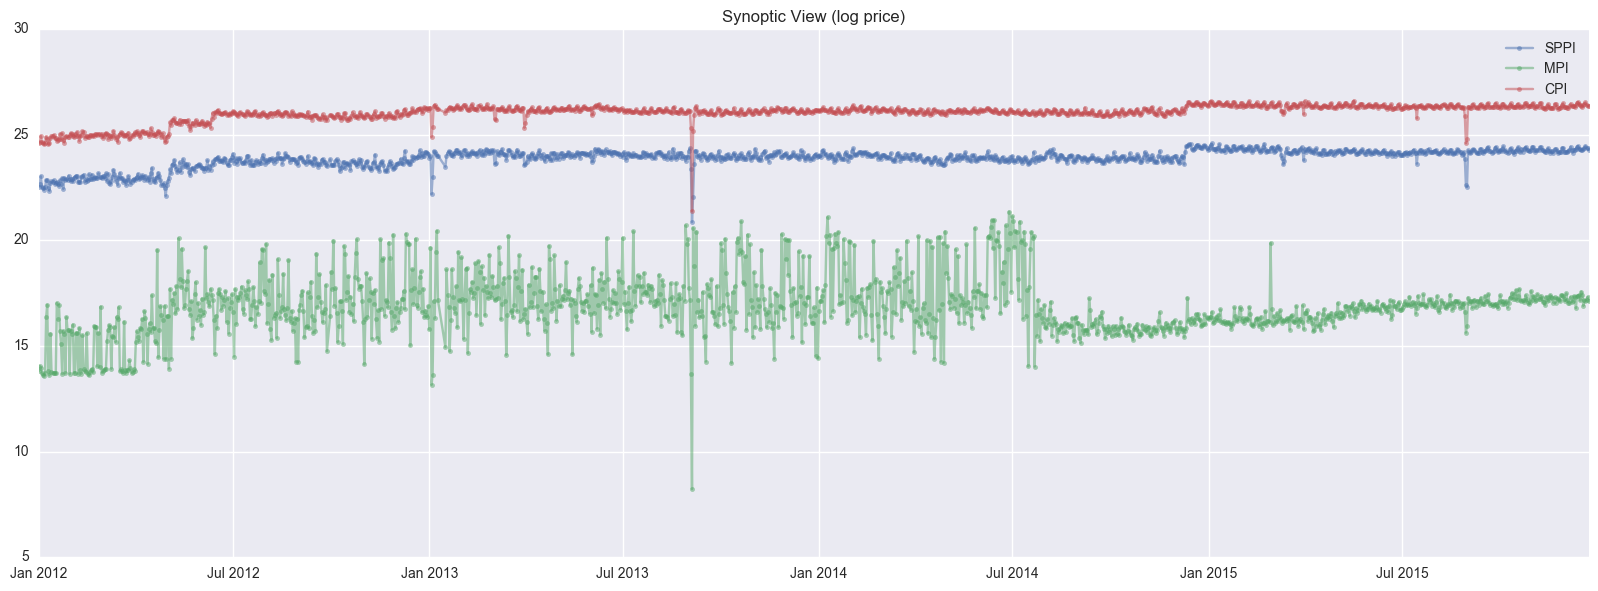

In [176]:
import matplotlib.patches as mpatches

plt.figure(1, figsize=(20,15))
plt.subplot(211)
plt.plot_date(df_sppi['ds'], y=df_sppi['y'],
              linestyle='-', label='SPPI', alpha=.5, fmt='.')
plt.plot_date(df_mpi['ds'], y=df_mpi['y'],
              linestyle='-', label='MPI', alpha=.5, fmt='.')
plt.plot_date(df_cpi['ds'], y=df_cpi['y'],
              linestyle='-', label='CPI', alpha=.5, fmt='.')
plt.title('Synoptic View (log price)')
plt.legend()
plt.show()

## Aufgabe 2: Vorhersage Preisentwicklung
* tägliche Werte für die Tage vom 24.12.15 bis 01.01.16
* wöchentliche Werte für den Januar 2016
* monatliche Werte für Januar, Februar und März 2016

### Filtering

In [12]:
# moving median for outlier detection (atm not used)
# https://bugra.github.io/work/notes/2014-03-31/outlier-detection-in-time-series-signals-fft-median-filtering/
def get_median_filtered(signal, threshold = 3):
    """
    signal: is numpy array-like
    returns: signal, numpy array 
    """
    difference = np.abs(signal - np.median(signal))
    median_difference = np.median(difference)
    s = 0 if median_difference == 0 else difference / float(median_difference)
    mask = s > threshold
    signal[mask] = np.median(signal)
    return signal

In [13]:
window_size = 20
median_filtered_signal = []

for ii in range(0, df_cpi.shape[0], window_size):
    median_filtered_signal += get_median_filtered(np.asanyarray(df_cpi['y'].values[ii: ii + window_size])).tolist() 

In [14]:
df_cpi['ds'].iloc[-1]

datetime.date(2015, 12, 23)

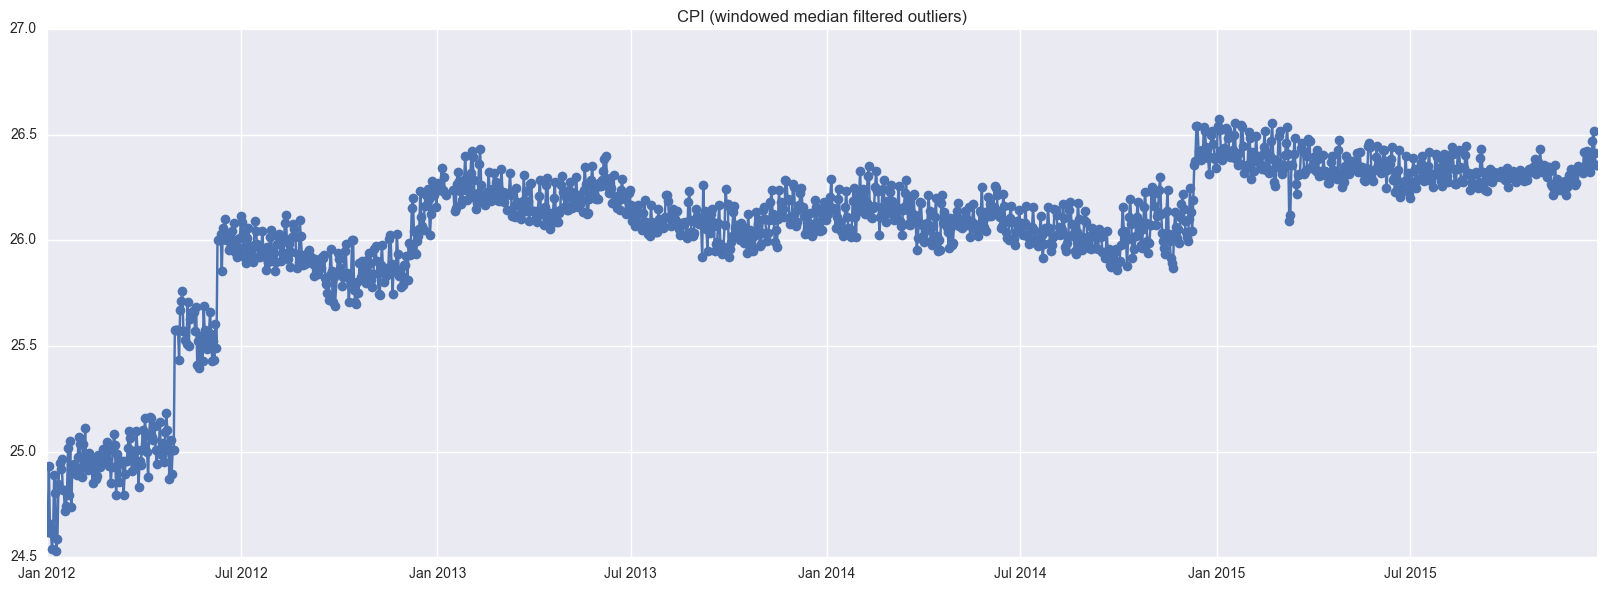

In [15]:
plt.figure(1, figsize=(20,15))
plt.subplot(211)
plt.plot_date(df_cpi['ds'], y=median_filtered_signal,
              linestyle='-')
plt.title('CPI (windowed median filtered outliers)')
plt.show()

### CPI

In [26]:
%%time
cpip = Prophet()
cpip.fit(df_cpi)
cpi_future = cpip.make_future_dataframe(periods=98)
cpi_forecast = cpip.predict(cpi_future)

CPU times: user 8.82 s, sys: 290 ms, total: 9.11 s
Wall time: 9.4 s


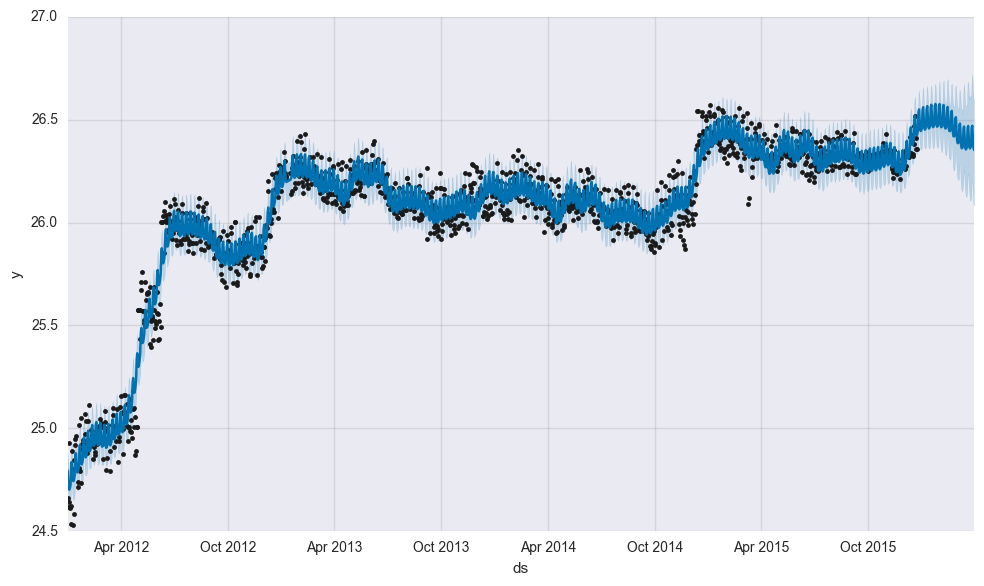

In [27]:
_ = cpip.plot(cpi_forecast)

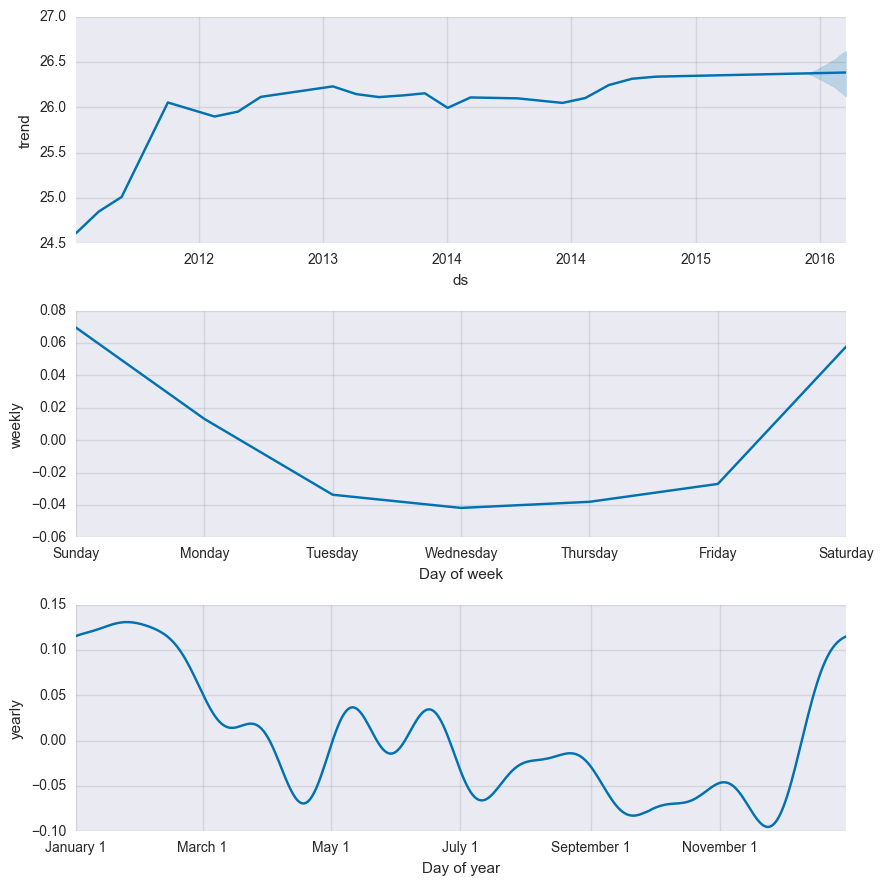

In [28]:
_ = cpip.plot_components(cpi_forecast)

## MPI

In [53]:
%%time
mpip = Prophet()
mpip.fit(df_mpi)
mpi_future = mpip.make_future_dataframe(periods=98)
mpi_forecast = mpip.predict(mpi_future)

CPU times: user 6.52 s, sys: 114 ms, total: 6.64 s
Wall time: 6.76 s


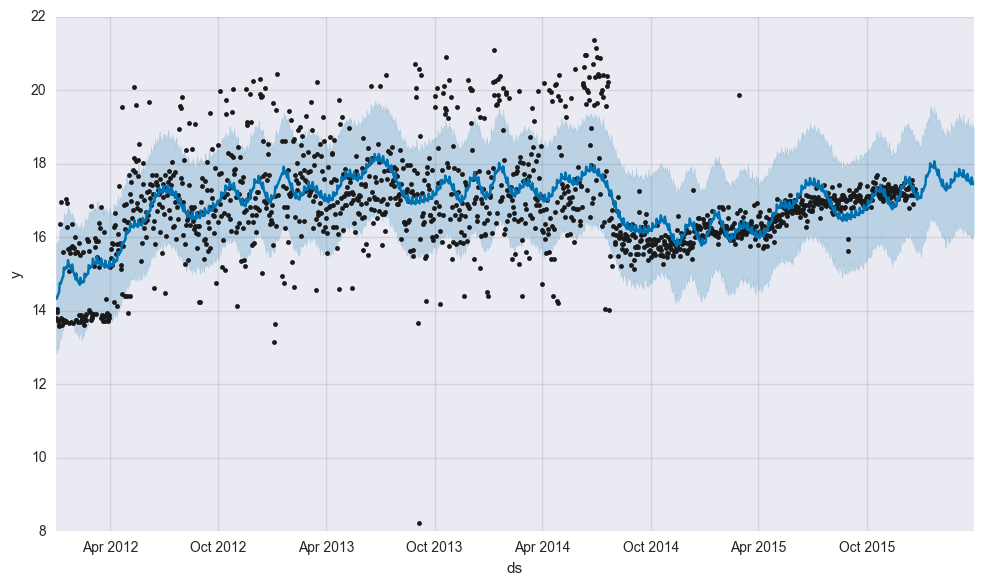

In [54]:
_ = mpip.plot(mpi_forecast)

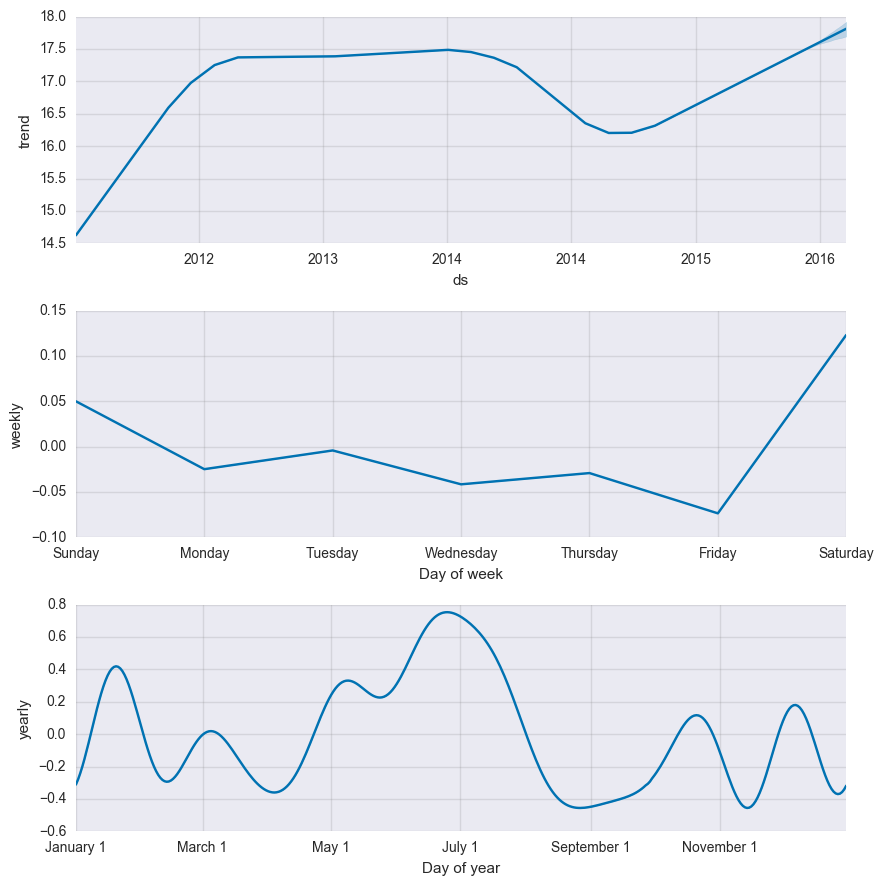

In [55]:
_ = mpip.plot_components(mpi_forecast)

### SPPI

In [44]:
%%time
sppip = Prophet()
sppip.fit(df_sppi)
sppip_future = sppip.make_future_dataframe(periods=98)
sppip_forecast = sppip.predict(sppip_future)

CPU times: user 7.91 s, sys: 107 ms, total: 8.02 s
Wall time: 8.16 s


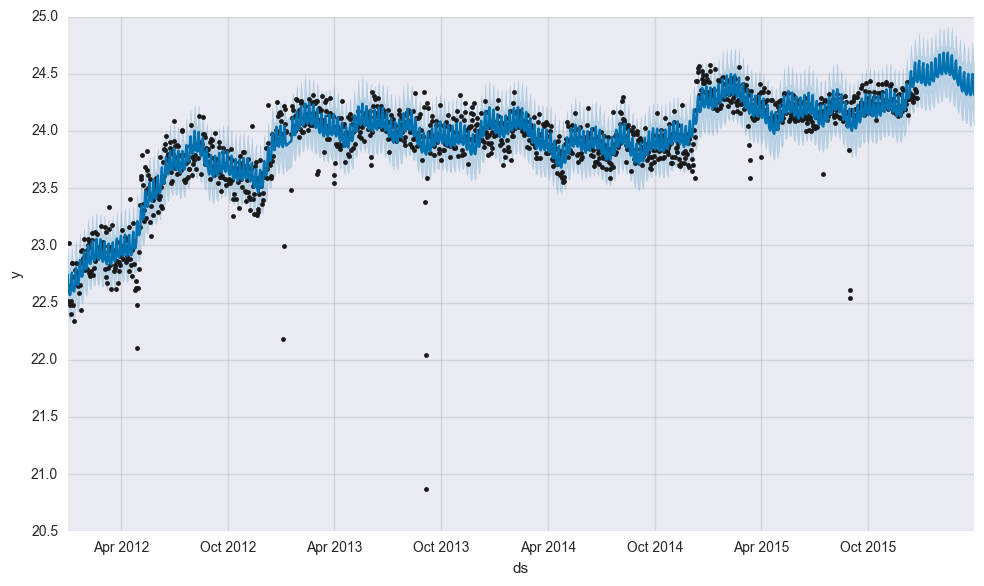

In [45]:
_ = sppip.plot(sppip_forecast)

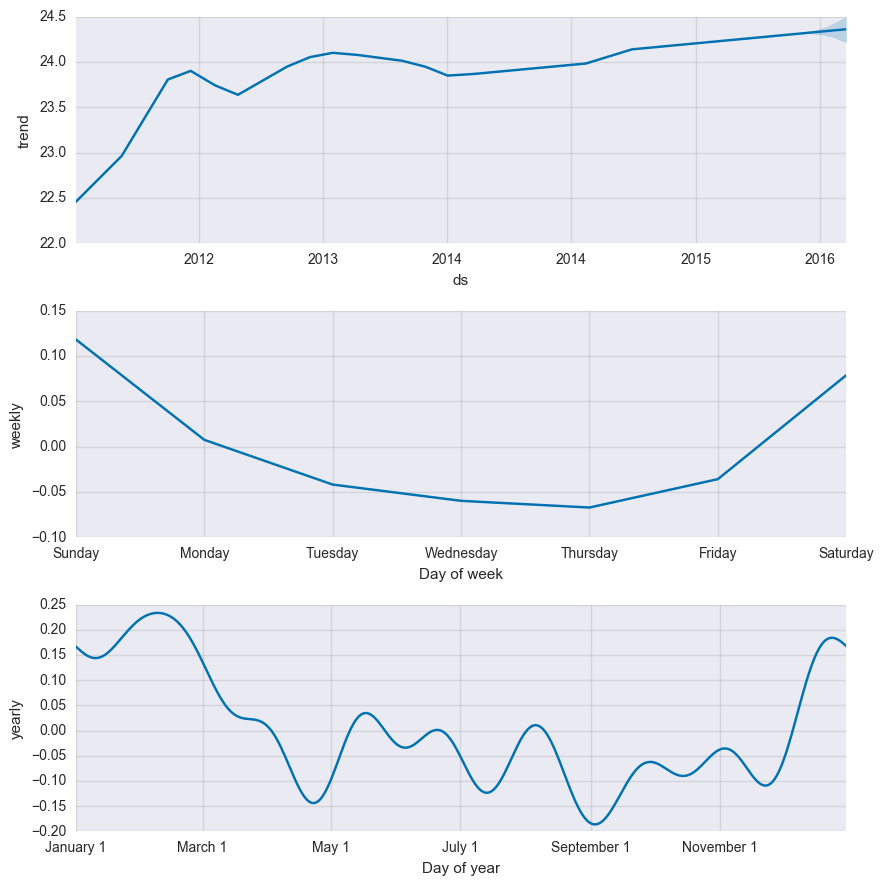

In [46]:
_ = sppip.plot_components(sppip_forecast)

---
## Data Export

In [24]:
def days_for_range(start, end):
    return (pd.to_datetime(end) - pd.to_datetime(start)).days

In [25]:
# forecast horizons:
# 1. 24.12.15 to 01.01.16 (9 days)
# 2. weeks of january (30 days (1.1. is already accounted for))
# 3. months of january to march
days = days_for_range("2015-12-24", "2016-03-31")
print(days)

98


In [47]:
def process_forecast(f):
    days_of_december = f.iloc[-99:-90]
    week1_of_jan = f.iloc[-88:-81]
    week2_of_jan = f.iloc[-81:-74]
    week3_of_jan = f.iloc[-74:-67]
    week4_of_jan = f.iloc[-67:-60]
    days_of_january = f.iloc[-91:-60]
    days_of_february = f.iloc[-60:-31]
    days_of_march = f.iloc[-31:]

    ## values
    # http://kalenderwoche.net/alle-kalenderwochen-2016.php
    # kw1: 4.1.-10.1.
    # kw2: 11.1-17.1.
    # kw3: 18.1.-24.1.
    # kw4: 25.1.-31.1.

    day_labels = list(map(lambda d: str(d).split('T')[0],#).strftime('%Y-%m-%d'),
                           days_of_december['ds'].values))
    days = days_of_december['yhat'].values

    week_labels = ['kw1', 'kw2', 'kw3', 'kw4']
    weeks = [np.sum(week1_of_jan['yhat'].values),
             np.sum(week2_of_jan['yhat'].values),
             np.sum(week3_of_jan['yhat'].values),
             np.sum(week4_of_jan['yhat'].values),]

    month_labels = ['jan', 'feb', 'march']
    months = [np.sum(days_of_january['yhat'].values),
              np.sum(days_of_february['yhat'].values),
              np.sum(days_of_march['yhat'].values)]
    
    labels = (day_labels,
              week_labels,
              month_labels)
    values = (days, weeks, months)

    return (labels, values)

In [94]:
labels, cpi_data = process_forecast(cpi_forecast)
mpi_data = process_forecast(mpi_forecast)[1]
sppi_data = process_forecast(sppi_forecast)[1]

data = [np.hstack(labels),
        np.hstack(cpi_data),
        np.hstack(mpi_data),
        np.hstack(sppi_data)]

In [91]:
!rm ../output/aufgabe_2.csv

In [92]:
# Export Data
columns = ["type", "mpi_forecast", "cpi_forecast", "sppi_forecast"]

with open('../output/aufgabe_2.csv', 'a') as f:
    f.write(','.join(columns) + '\n')
    
    for l, c, m, s in np.array(data).T:
        f.write(','.join([l, c, m, s]) + '\n')

In [93]:
!cat ../output/aufgabe_2.csv

type,mpi_forecast,cpi_forecast,sppi_forecast
2015-12-23,26.42378572653504,17.09687414618932,17.09687414618932
2015-12-24,26.431863272444566,17.086044045005263,17.086044045005263
2015-12-25,26.446681203303648,17.02379904213644,17.02379904213644
2015-12-26,26.534831994770474,17.208676032360408,17.208676032360408
2015-12-27,26.549334568659393,17.130102300895356,17.130102300895356
2015-12-28,26.495330438553243,17.056607751414898,17.056607751414898
2015-12-29,26.450494850321686,17.085561984858117,17.085561984858117
2015-12-30,26.444059298042863,17.063510108684344,17.063510108684344
2015-12-31,26.449266985457346,17.09808243549048,17.09808243549048
kw1,185.44988938772676,121.69687389367886,121.69687389367886
kw2,185.49130472015253,124.3072152404249,124.3072152404249
kw3,185.5325405653207,125.62426649715627,125.62426649715627
kw4,185.54716895507318,124.80315049204697,124.80315049204697
jan,821.4791481662263,547.9261744539306,547.9261744539306
feb,768.1405713855722,506.7997108441383,506.7997108

---
## Experimental

## Patches
* patches as changepoints

In [16]:
cur.execute("SELECT * FROM patches")
patches = cur.fetchall()

In [17]:
df_patches = pd.DataFrame(patches,
                          columns=['name',
                                   'version',
                                   'build',
                                   'start',
                                   'end'])

In [21]:
df_patches.columns

Index(['name', 'version', 'build', 'start', 'end'], dtype='object')

In [29]:
import datetime as dt

In [58]:
def patches_to_days(df):
    s = pd.to_datetime(df['start'])
    e = pd.to_datetime(df['end'])
    v = df['version']
    n = df['name']
    b = df['build']
    descr = []
    d = []
    
    for i, t in enumerate(zip(n, v, b)):
        _n, _v, _b = t

        if _b:
            descr.append("%s %s (%s)" % (_n, _v, _b))
        else:
            descr.append("%s %s" % (_n, _v))
            
        s_i = s[i]
        e_i = e[i]
        days = (e_i - s_i).days
        _d = []
        
        
        for day in range(days):
            _d.append((s_i + dt.timedelta(day)))
            
        d.append(pd.to_datetime(_d))
        
        
    return pd.DataFrame(data=[s, e, descr, d],
                        columns=['start',
                                 'end',
                                 'description',
                                 'single_days'])
    
print(patches_to_days(df_patches))

AttributeError: 'builtin_function_or_method' object has no attribute 'get_indexer'

In [41]:
print(df_patches['start'].values[0])
print(df_patches['start'].values[0] + dt.timedelta(1))

2012-03-13
2012-03-14


In [11]:
import bayesian_changepoint_detection.offline_changepoint_detection as offcd
from functools import partial

In [12]:
Q, P, Pcp = offcd.offline_changepoint_detection(df_cpi['y'], partial(offcd.const_prior, l=(len(df_cpi['y'])+1)), offcd.gaussian_obs_log_likelihood, truncate=-40)

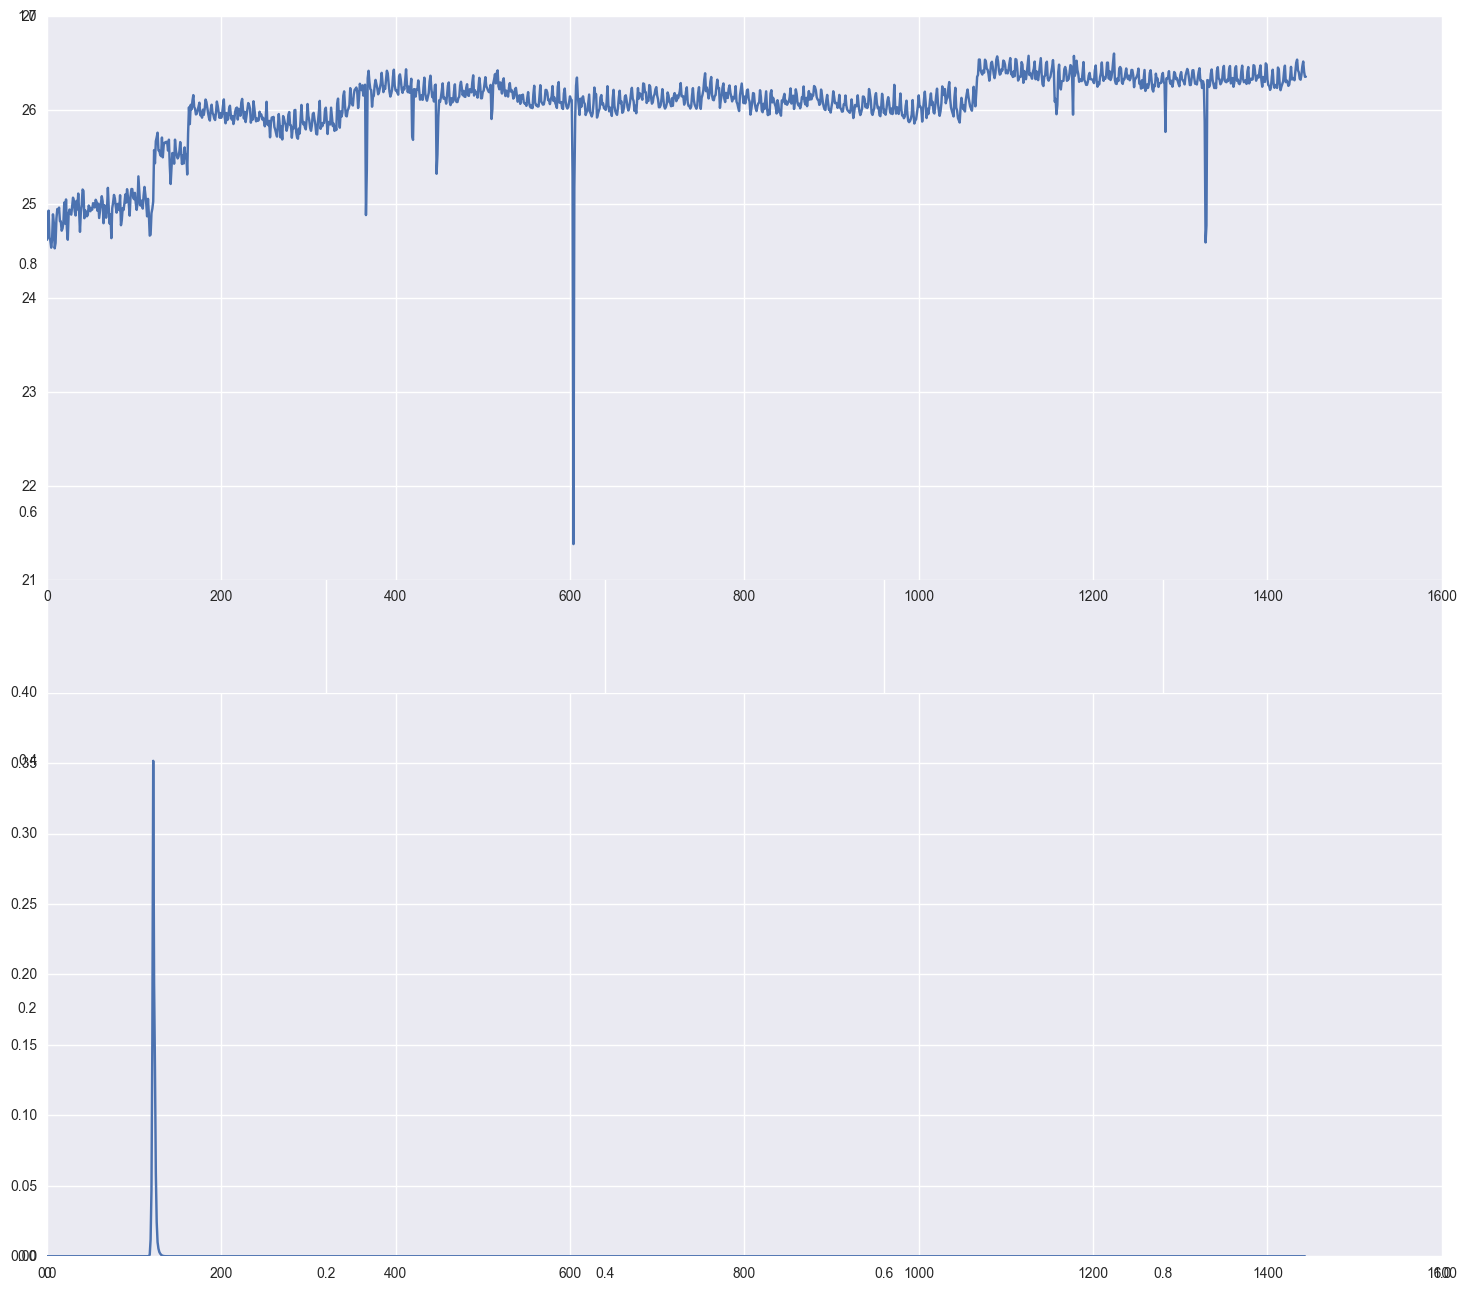

In [16]:
fig, ax = plt.subplots(figsize=[18, 16])
ax = fig.add_subplot(2, 1, 1)
ax.plot(df_cpi['y'])
ax = fig.add_subplot(2, 1, 2, sharex=ax)
ax.plot(np.exp(Pcp).sum(0))
plt.show()

In [18]:
from changepy import pelt
from changepy.costs import normal_mean

In [20]:
help(normal_mean)

Help on function normal_mean in module changepy.costs:

normal_mean(data, variance)
    Creates a segment cost function for a time series with a
        Normal distribution with changing mean
    
    Args:
        data (:obj:`list` of float): 1D time series data
        variance (float): variance
    Returns:
        function: Function with signature
            (int, int) -> float
            where the first arg is the starting index, and the second
            is the last arg. Returns the cost of that segment



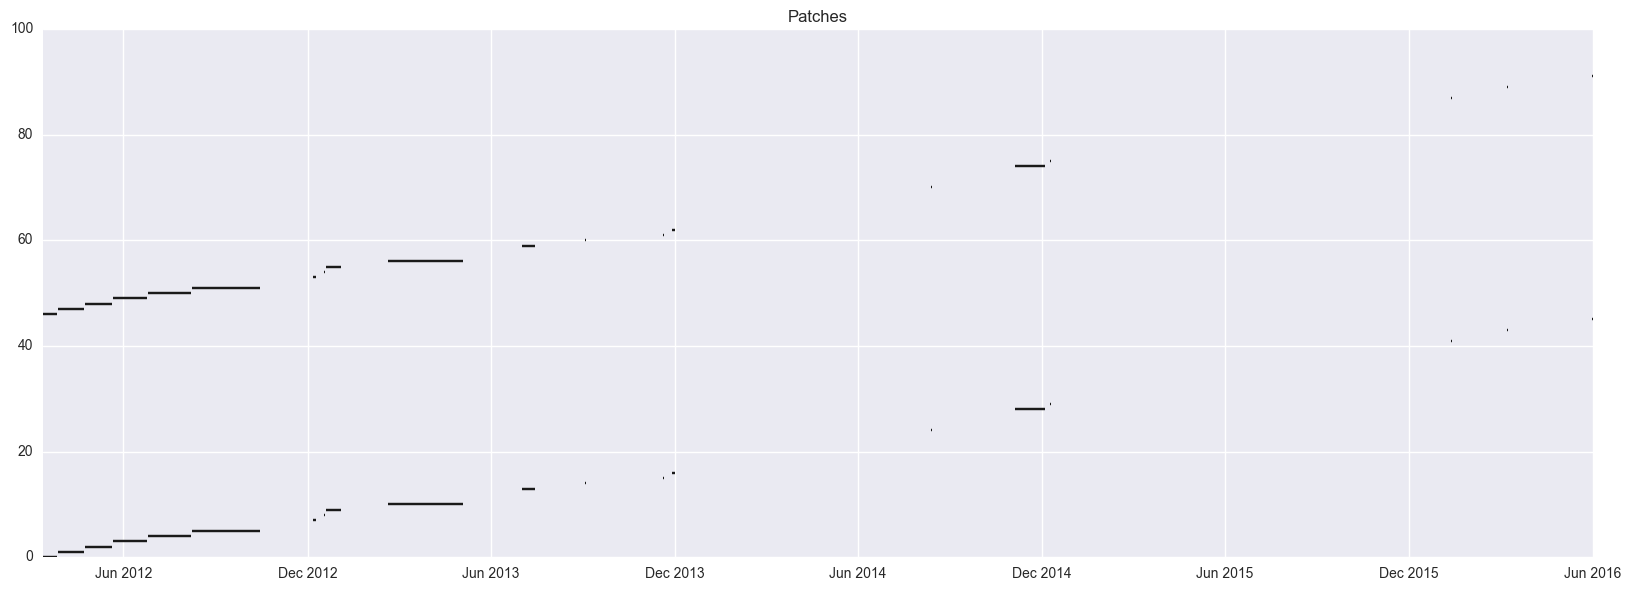

In [18]:
import matplotlib.dates as dates

x = dates.date2num(df_patches['start'])
y = dates.date2num(df_patches['end'])
labels = ["%s %s" % (name, version) for name, version in zip(df_patches['name'].values,
                                                            df_patches['version'].values)]

fig = plt.figure(1, figsize=(20,15))
ax = plt.subplot(211)
ax = ax.xaxis_date()
# plt.subplot(211)
# plt.plot_date(df_cpi['ds'], y=df_cpi['y'],
              linestyle='-')
# plt.title('CPI (raw)')
ax = plt.hlines(df_patches.index, x, y)
# plt.xticks(range(len(labels)), labels, size='small')

# for i, pair in enumerate(zip(x,y)):
#     plt.annotate(labels[i], xy=pair, xytext=(0,0))

plt.title('Patches')
plt.show()

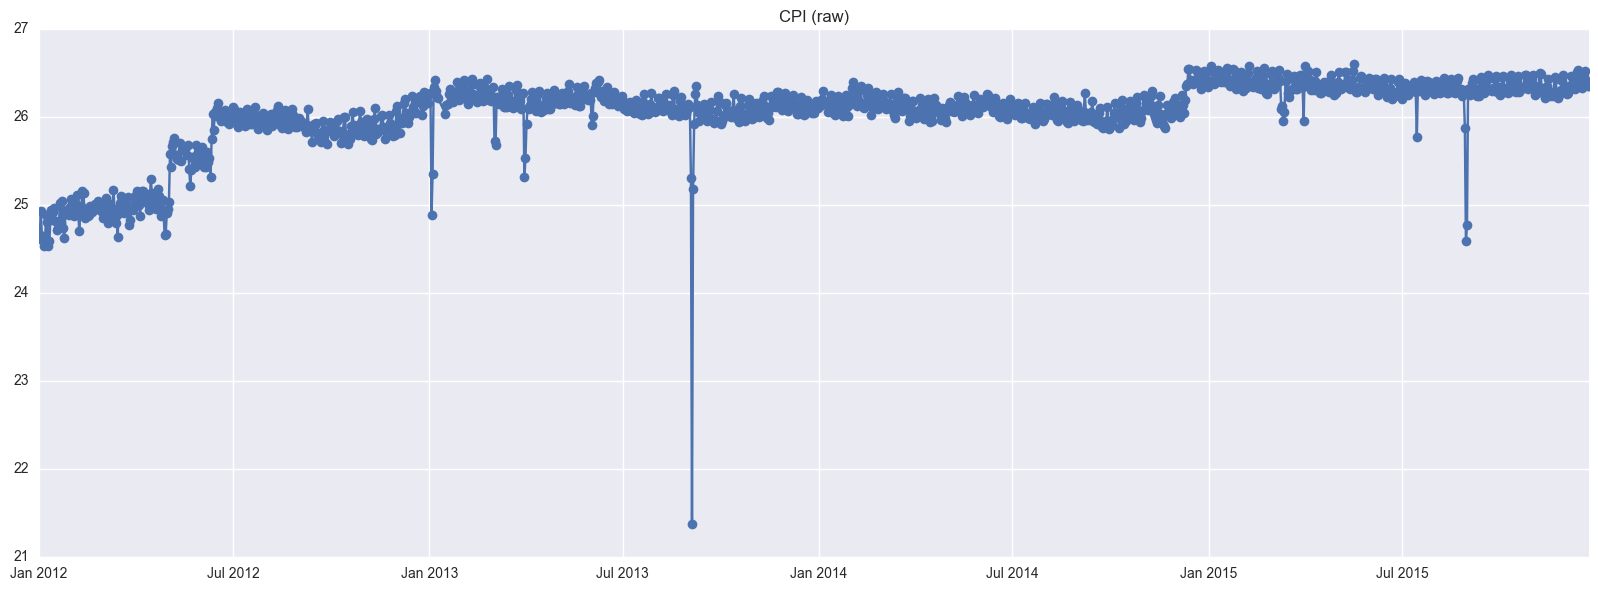

In [12]:
plt.figure(1, figsize=(20,15))
plt.subplot(211)
plt.plot_date(df_cpi['ds'], y=df_cpi['y'],
              linestyle='-')
plt.title('CPI (raw)')

plt.show()

In [22]:
# TODO: quantify patches

## Holidays
* check for some countries if (some of) the holidays correlate to the time series (maybe the outliers?)

In [4]:
christmas = pd.DataFrame({
    'holiday': 'christmas',
    'ds': pd.to_datetime([
        '2012-12-23',
        '2012-12-24',
        '2012-12-25',
        '2012-12-26',
        '2013-12-23',
        '2013-12-24',
        '2013-12-25',
        '2013-12-26',
        '2014-12-23',
        '2014-12-24',
        '2014-12-25',
        '2014-12-26',
        '2015-12-23',
        '2015-12-24',
        '2015-12-25',
        '2015-12-26',
        '2016-12-23',
        '2016-12-24',
        '2016-12-25',
        '2016-12-26'
    ])
})

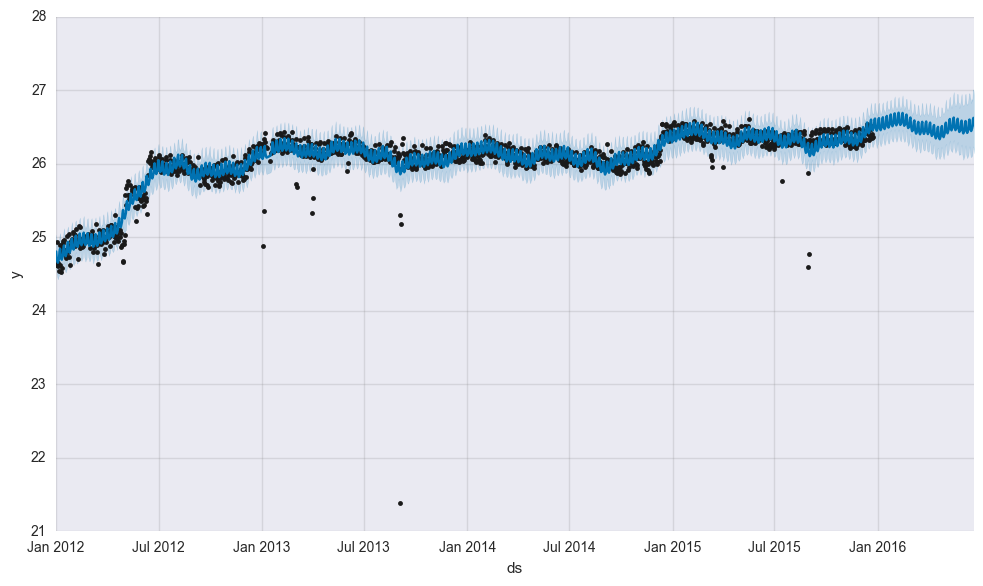

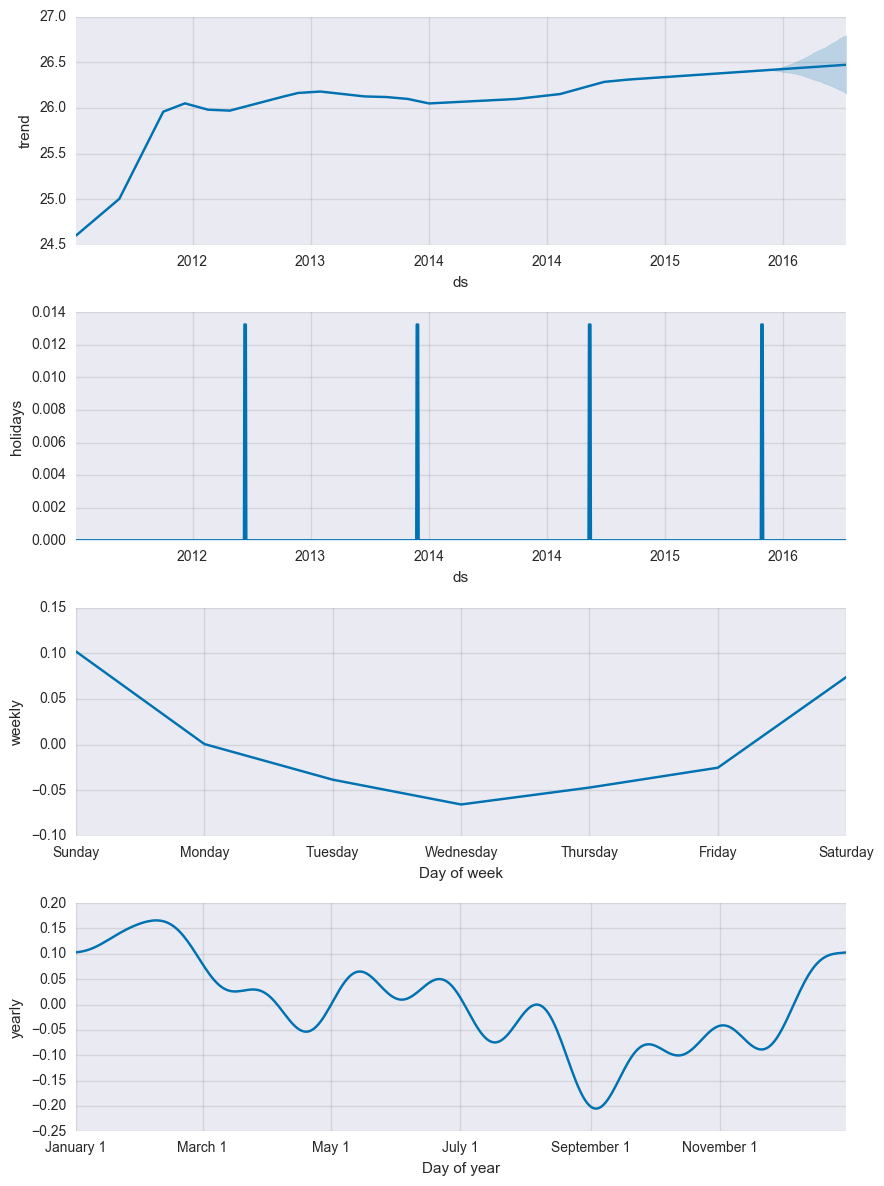

In [12]:
prophet = Prophet(holidays=christmas)
prophet.fit(df_cpi)
future = prophet.make_future_dataframe(periods=180)
yh = prophet.predict(future)
p = prophet.plot(yh)
p = prophet.plot_components(yh)

In [15]:
prophet.holidays


,ds,holiday
0,2012-12-23,christmas
1,2012-12-24,christmas
2,2012-12-25,christmas
3,2012-12-26,christmas
4,2013-12-23,christmas
5,2013-12-24,christmas
6,2013-12-25,christmas
7,2013-12-26,christmas
8,2014-12-23,christmas
9,2014-12-24,christmas


## Detrending

In [24]:
from statsmodels.tsa.tsatools import detrend

In [30]:
detrended = detrend(df_cpi['y'])

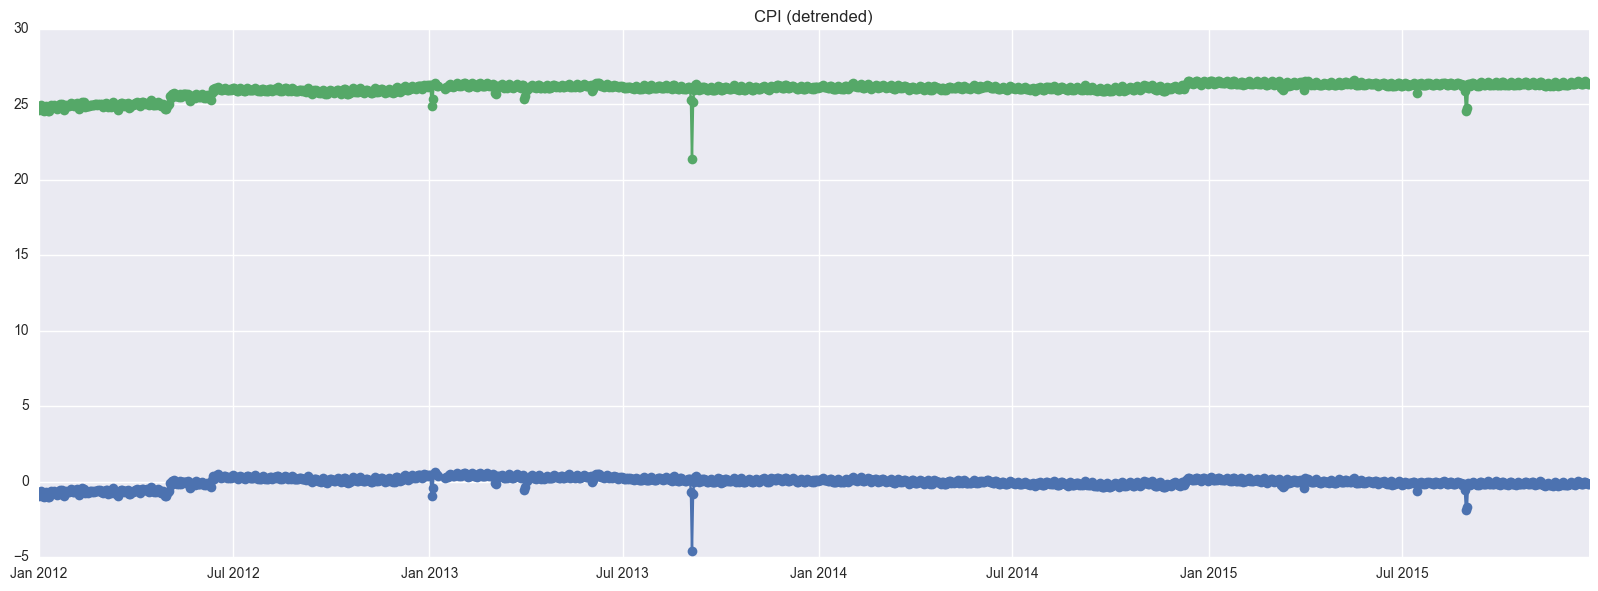

In [32]:
plt.figure(1, figsize=(20,15))
plt.subplot(211)
plt.plot_date(df_cpi['ds'], y=detrended,
              linestyle='-')
plt.plot_date(df_cpi['ds'], y=df_cpi['y'],
              linestyle='-')
plt.title('CPI (detrended)')

plt.show()

## Simulated Historical Forecasts
For a forecast horizon $H$ (i.e. $180$ days) the data is split into all possible half years after the first year. For each horizon $h$ a forecast is made up until the last date of data. A heuristic also used at facebook [Prophet paper] is to set the forecast periods to the cumulative of $H/2$

In [24]:
from pypythia import Experiment, Model

In [25]:
exp = Experiment(api_base='http://localhost:5667/api/v1', _id='58d3e43278b53b4371a3688f')

In [26]:
exp.name = "Data Science Cup 2017 | Aufgabe 2"

In [27]:
m1 = exp.create_model()
m1.name = "CPI raw"

In [14]:
# step 1: split time series into periods
# TODO: make lazy
def splits(df, H):
    N = df.shape[0]
    # keep first year to have "enough" data
    step = int(floor((H/2)))
    n_periods = (N - 365) / step
    out = []
    
    start = 364
    end = start + step
    
    while (end <= N):
        out.append((0, end))
        start = end + 1
        end = start + step
    
    if end != (N - 1):
        # start = end + 1
        end = N - 1
        out.append((0, end))
        
    return out
        

# splits(df_cpi, 91)

In [15]:
# SMAPE

def smape(obs, pred):
    assert len(obs) == len(pred), "lengths have to be equal"
    out = []

    for o, p in zip(obs, pred):
        out.append(abs(p - o) / ((abs(o) + abs(p)) / 2))
    
    return out

In [36]:
def shf(data, create_model, H, error):
    """
    Params
    ------

    data : (pandas data frame)
        the data with columns `y` and `ds`, where
        `y` contains the measurement and `ds` timestamps
        of discrete measurement points

    create_model: (function)
        function that is to be called with (data, horizon).
        the function should create the model, fit to the
        data and return the forecasted values as a 1-d array
        or a tuple of the model and the forecasted values
        (model, y_predicted).

    error: (function)
        function that is called with (y, y_predicted) to evaluate
        the performance for an array of predicted values.

    Returns
    -------
    Tuple of (models, errors) if `create_model` returns the model,
    otherwise only a 1-d array of errors.
    """
    ss = splits(data, H)
    ms = []
    es = []
    means = []

    for s in ss:
        h = data.shape[0] - s[1]
        the_slice = data.iloc[s[0]:s[1]]
        res = create_model(the_slice, h)

        if type(res) == tuple:
            m, yh = res
            ms.append(m)

        else:
            yh = res

        obs = data['y'][s[1]+1:]

        if type(yh) == pd.core.frame.DataFrame:
            es.append(error(obs, yh['yhat'].values[s[1]+1:]))
        else:
            es.append(error(obs, yh[s[1]+1:]))

        means.append(np.mean(es[-1]))

    if len(ms) > 0:
        return (ms, es, means)
    else:
        return (es, means)


/usr/local/lib/python3.6/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  if rcount == 0:
/usr/local/lib/python3.6/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = umr_sum(arr, axis, dtype, out, keepdims)


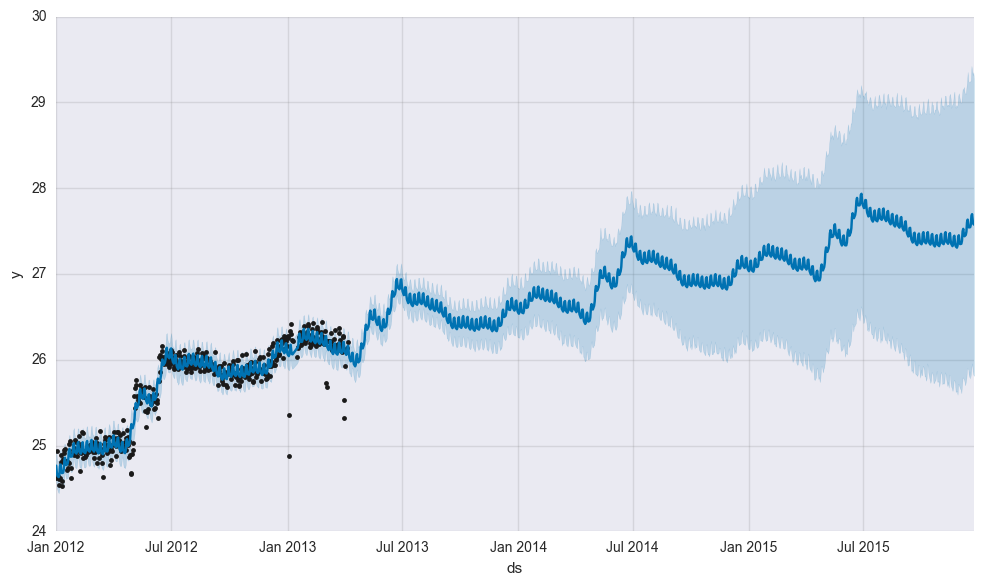

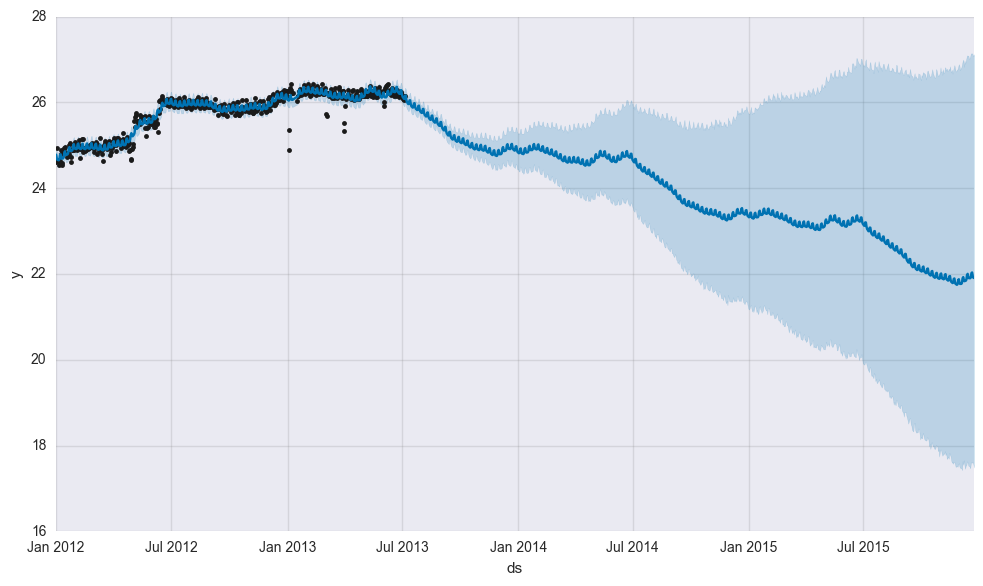

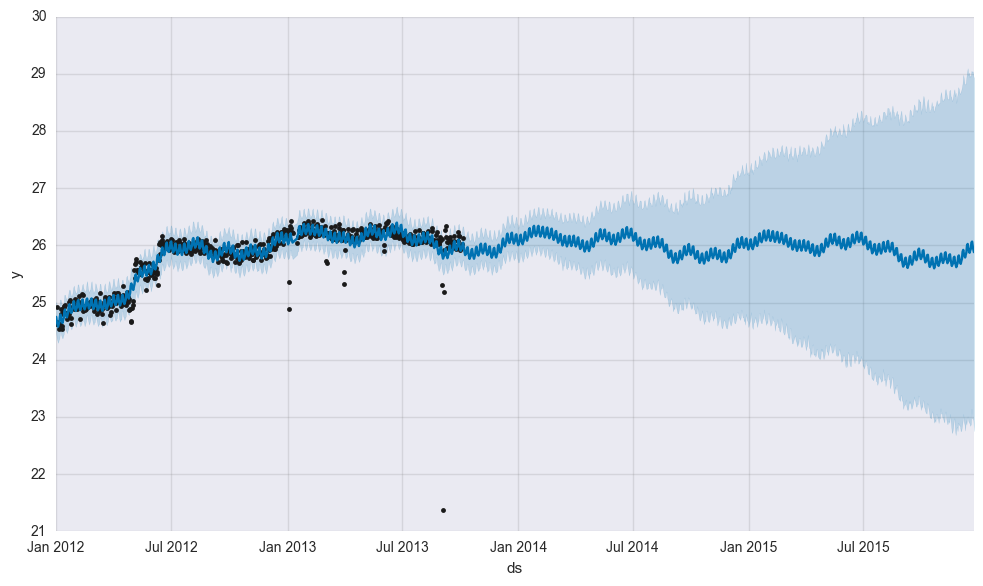

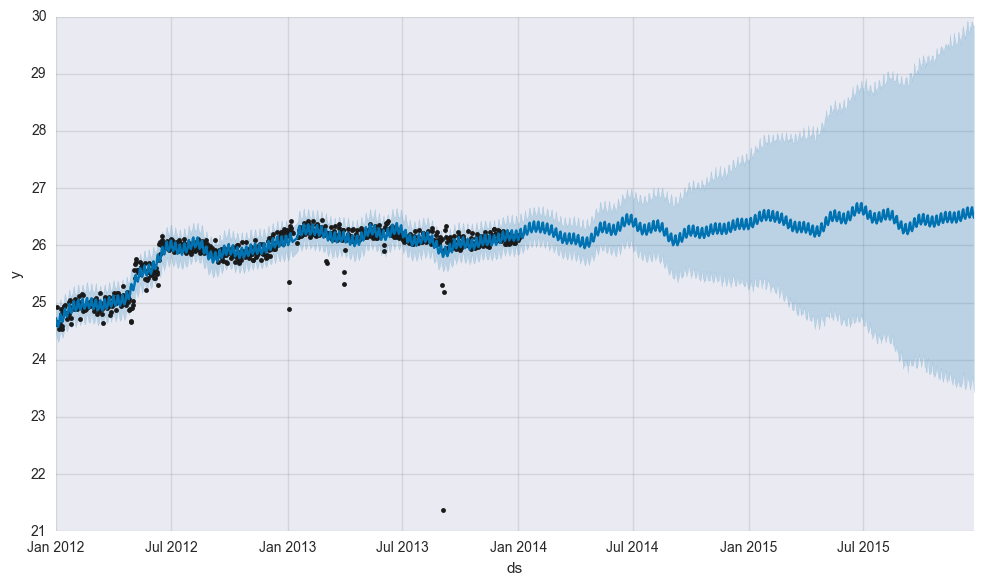

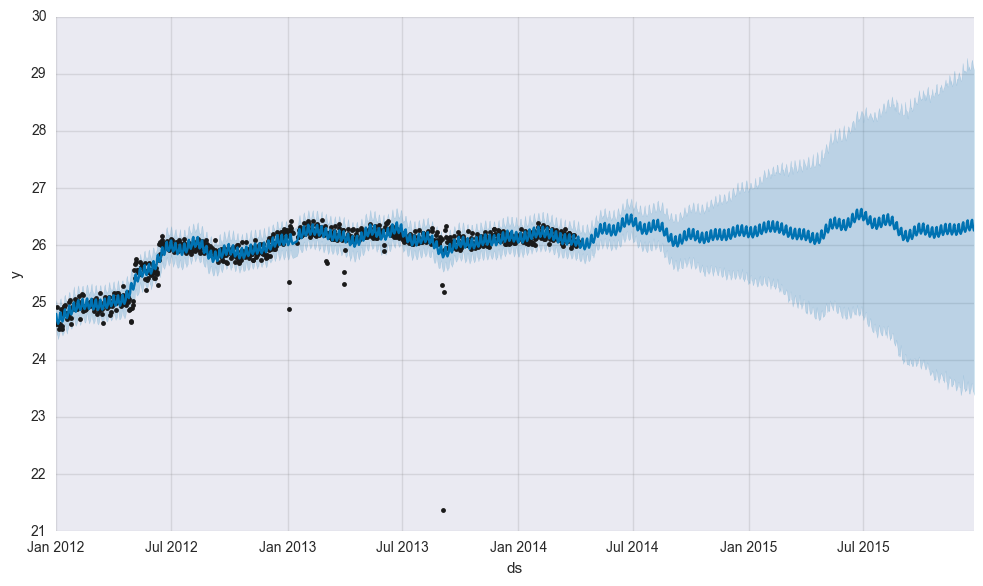

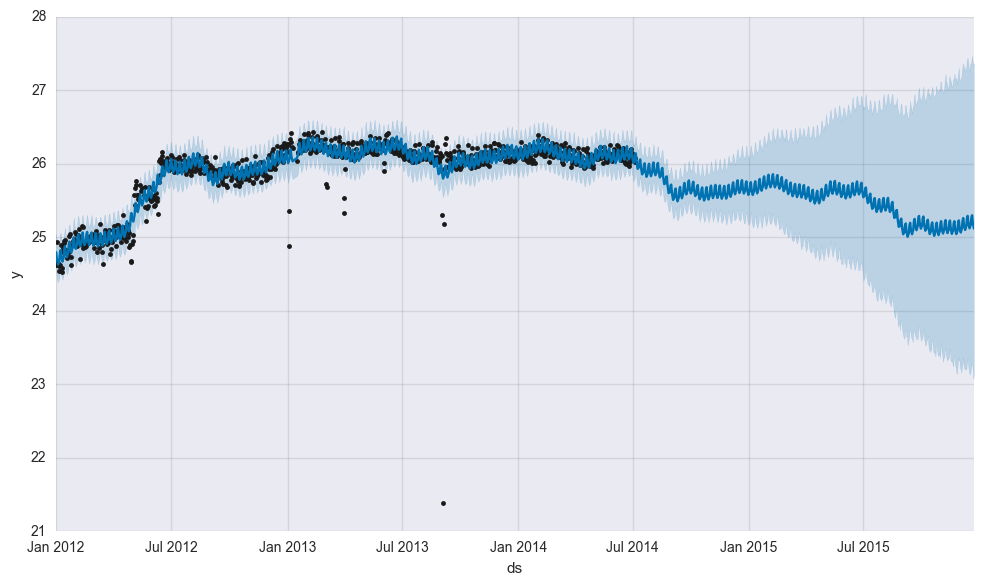

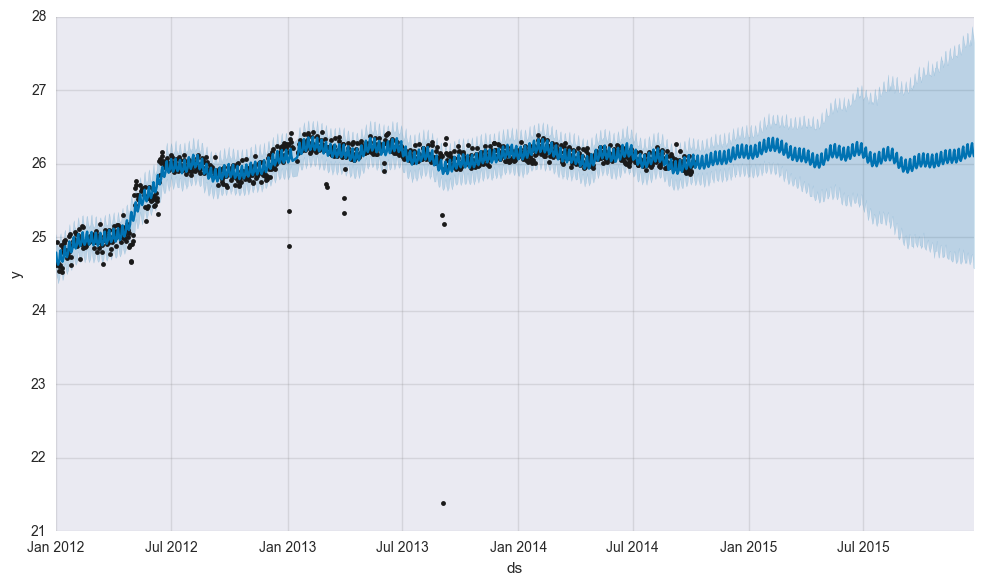

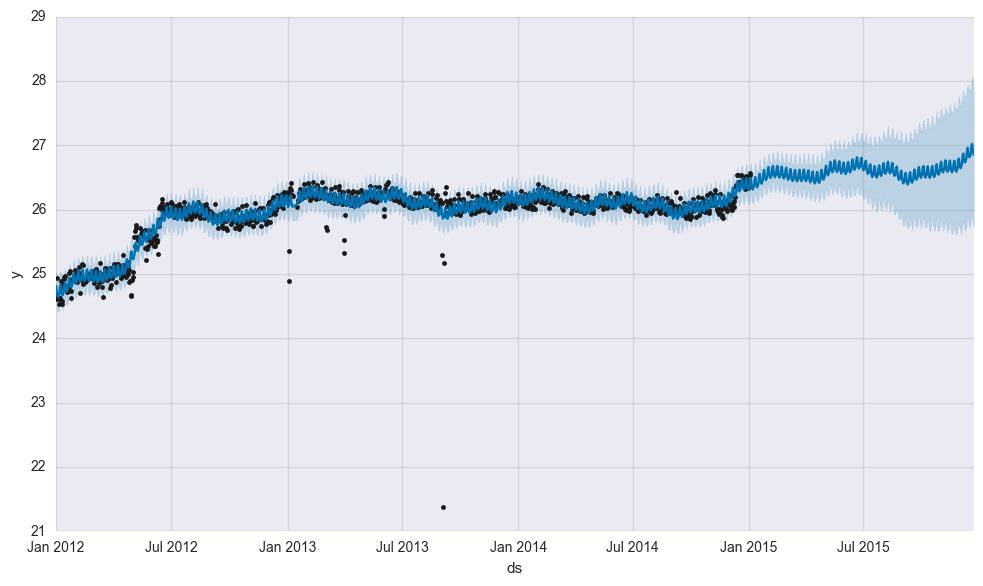

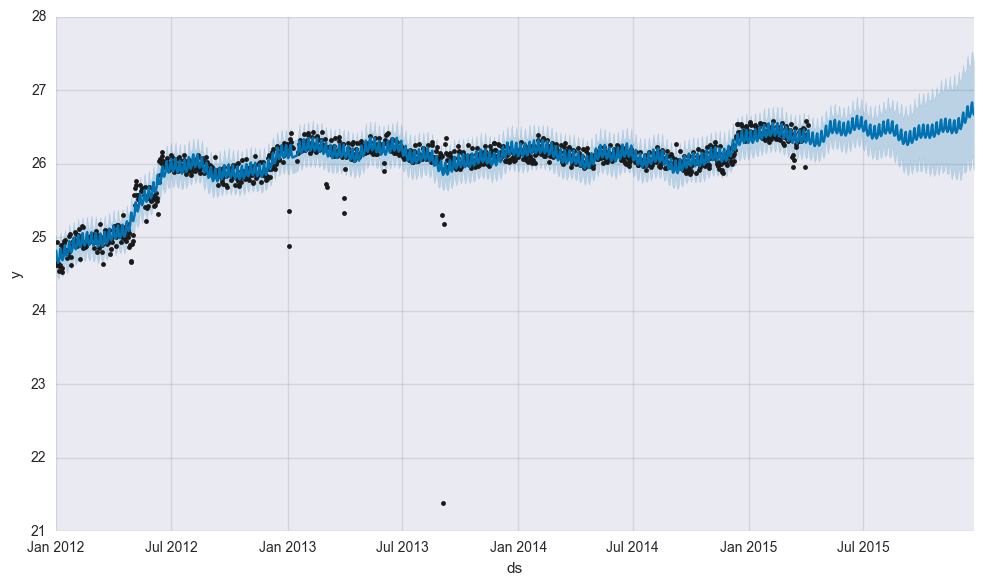

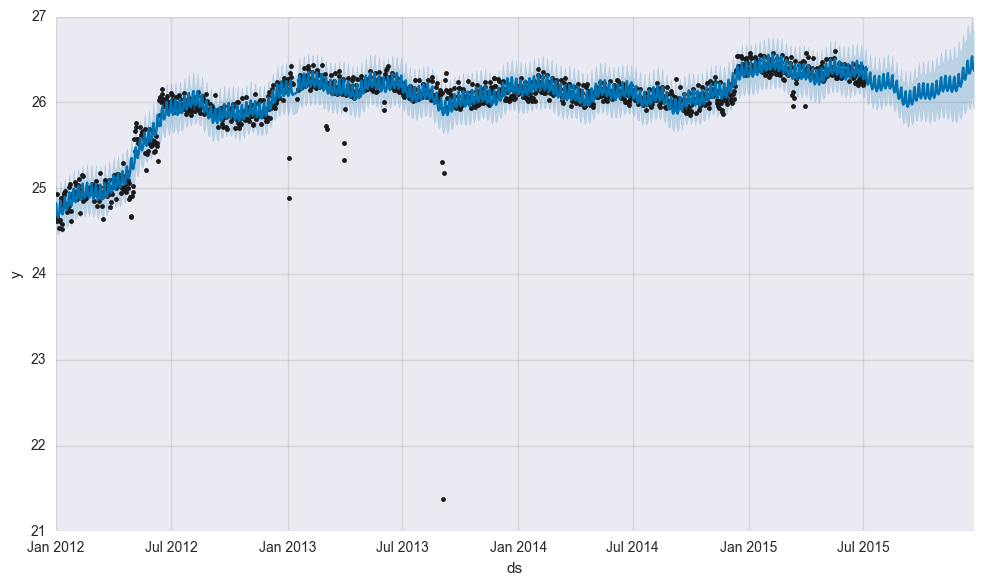

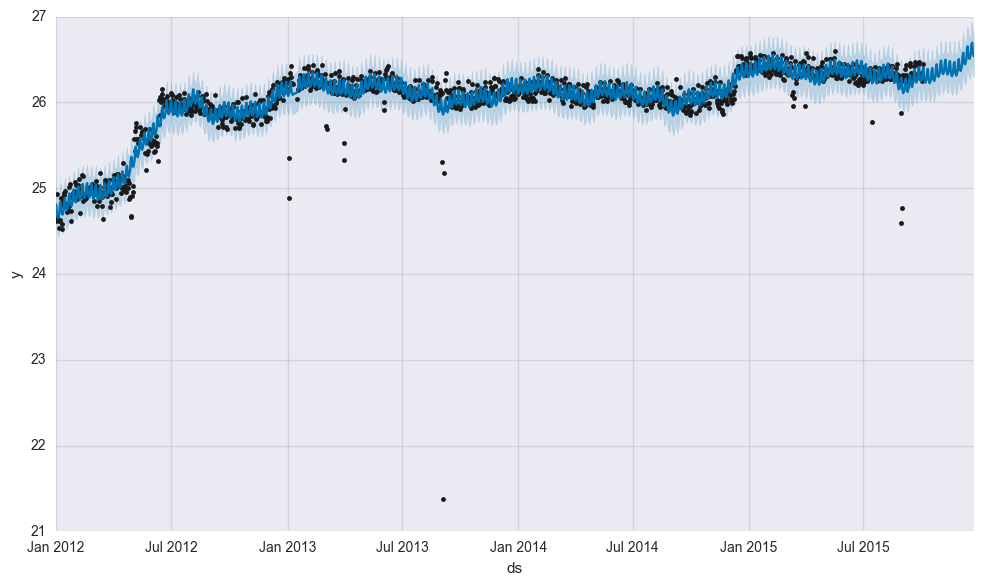

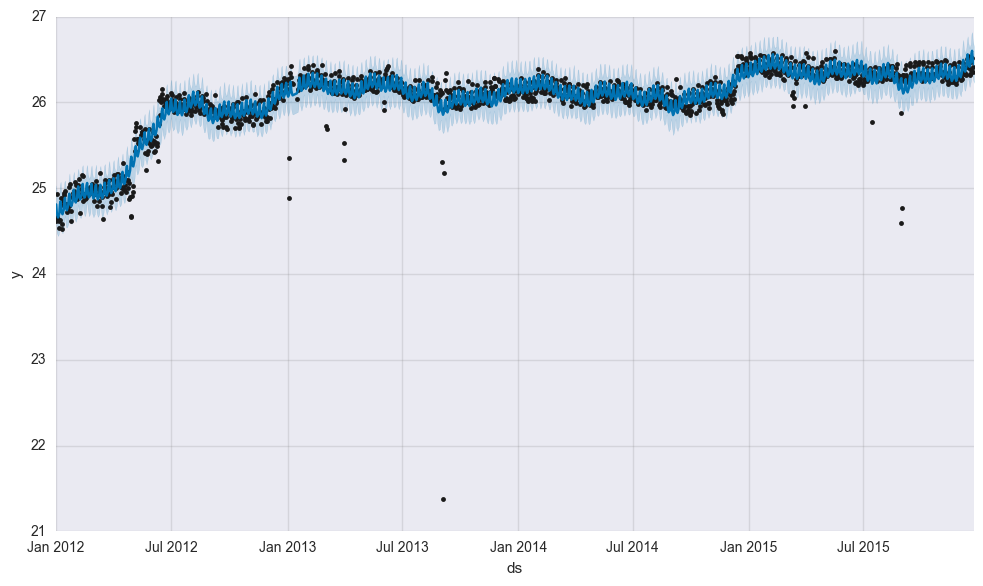

In [37]:
def cm(data, H):
    prophet = Prophet()
    prophet.fit(data)
    future = prophet.make_future_dataframe(periods=H)
    yh = prophet.predict(future)
    p = prophet.plot(yh)
    # p = prophet.plot_components(yh)

    return (p, yh)

out = shf(df_cpi, cm, 180, smape)

In [1]:
# TODO: compare versions with holidays/patches and so on against
# each other and the baseline (without any extras) via sh